# <b style="font-family:Roboto Condensed"> Kaggle: House Prices- Advanced Regression Techniques

In [1]:
# Uncomment if you need to install these packages
!pip install -U --pre pycaret --quiet
!pip install catboost --quiet
!pip install optuna --quiet

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
pandas-profiling 3.1.0 requires joblib~=1.0.1, but you have joblib 1.2.0 which is incompatible.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.2 which is incompatible.
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
# Dependencies
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret
import optuna
#import lightgbm as lgb

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from pycaret.regression import setup, compare_models

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, Ridge, OrthogonalMatchingPursuit
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


#sns.set_style('darkgrid')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import the Data

In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
#Define the target (outcome)
target = train['SalePrice']

#Store the test IDs
test_ids = test['Id']

# Drop the IDs
train = train.drop(['Id', 'SalePrice'], axis=1)
test = test.drop('Id', axis=1)

### Combine Data
To get the most predictive power out of the data, we can combine our testing and training data and then split them back out later. 

In [5]:
# Concatenate the dataframes vertically
data = pd.concat([train, test], axis=0).reset_index(drop=True)

In [6]:
#List all variables and types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

The outcome of interest is the sale price

In [7]:
print("Median sale price:", target.median())

Median sale price: 163000.0


<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

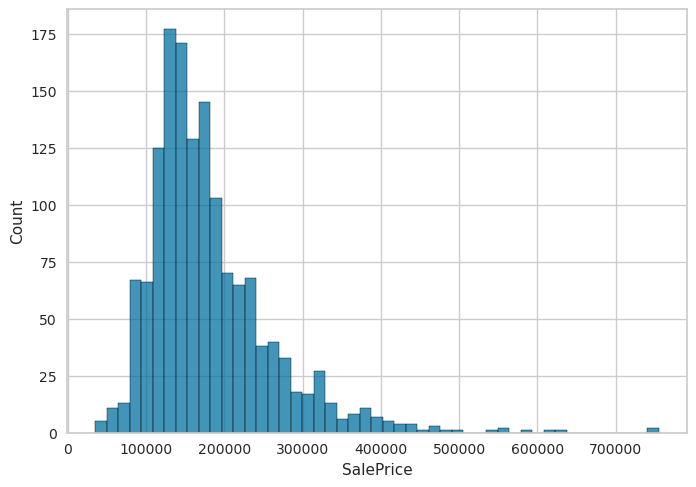

In [8]:
sns.histplot(target)

This gives us a reference for our predictions. If they are vastly different, we know something is wrong.

# Cleaning the Data

## Check for Missing Data

In [9]:
# Calculate the number of missing values in each column
missing_counts = data.isna().sum()

# Filter for columns with missing data
missing_cols = missing_counts[missing_counts > 0]

# Print the columns with missing data and their respective missing value counts
print("Columns with missing data:")
print(missing_cols)


Columns with missing data:
MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64


Looking at the list above, we need to determine which variables can be imputed and which variables aren't really missing, but maybe labeling in such a way.

For many of these variables, the values aren't really missing, they just don't have the features. For example, NA on Alley means there's no alley access, not that the data is missing. We'll go through those and replace NA with 'None' to cleat that up.

In [10]:
for v in ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
          'BsmtExposure','BsmtFinType1','BsmtFinType2', 
          'FireplaceQu', 'GarageType', 'GarageYrBlt',
          'GarageFinish', 'GarageQual', 'GarageCond', 
          'PoolQC','Fence', 'MiscFeature']:
    data[v].fillna('None', inplace=True)

### Categorical missing
For data missing from categorical variables, we can replace it with the modal (most common) value. 

In [11]:
for v in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data[v] = data[v].fillna(data[v].mode()[0])

### Numeric missing

You can impute based on the mean, but since we have so much data, we can use it to try and predict a better value to impute. 

One approach is to use K Nearest Neighbor imputation.

In [12]:
imputer = KNNImputer(n_neighbors=5)

for v in ['LotFrontage','BsmtFinSF1','BsmtFinSF2',
          'BsmtUnfSF','TotalBsmtSF','BsmtFullBath',
          'BsmtHalfBath','GarageCars','GarageArea',
          'MasVnrArea']:
    data[v] = imputer.fit_transform(data[[v]])

We can once again check for missing values:

In [13]:
missing_counts = data.isna().sum()
missing_cols = missing_counts[missing_counts > 0]
print(missing_cols)

Series([], dtype: int64)


We see that no missing data remains. 

## Check Variable Types

In [14]:
data.select_dtypes(np.number)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2.0,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,2.0,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2.0,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,3.0,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,3.0,836.0,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,0.0,0.0,0,0,0,0,0,0,0,6,2006
2915,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1.0,286.0,0,24,0,0,0,0,0,4,2006
2916,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,2.0,576.0,474,0,0,0,0,0,0,9,2006
2917,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,0.0,0.0,80,32,0,0,0,0,700,7,2006


MSSubClass is actually categorical and not a numeric, so we need to change that.

In [15]:
data['MSSubClass']=data['MSSubClass'].astype(str)

# Feature Engineering

We know that home sales are very seasonal. We have a variable for month sold, so we can bring in some outside data to give us move information about the seller premium during certain months. 

Here, I've used <a href="https://www.attomdata.com/news/market-trends/home-sales-prices/attom-2022-best-days-to-sell-a-home-analysis/"> a report from ATTOM.</a>

In [16]:
# # Define the data as a list of dictionaries
# data2 = [
#         {'Month': 5, 'SellerPremium': 0.126},
#         {'Month': 6, 'SellerPremium': 0.107},
#         {'Month': 7, 'SellerPremium': 0.1},
#         {'Month': 4, 'SellerPremium': 0.092},
#         {'Month': 3, 'SellerPremium': 0.089},
#         {'Month': 9, 'SellerPremium': 0.079},
#         {'Month': 2, 'SellerPremium': 0.079},
#         {'Month': 8, 'SellerPremium': 0.079},
#         {'Month': 12, 'SellerPremium': 0.063},
#         {'Month': 1, 'SellerPremium': 0.062},
#         {'Month': 11, 'SellerPremium': 0.061},
#         {'Month': 10, 'SellerPremium': 0.052}]

# # Create the dataframe
# premiums = pd.DataFrame(data2)

# # Print the resulting dataframe
# print(premiums)

In [17]:
# # merge the dataframes on the 'Month' and 'MoSold' columns
# data = pd.merge(data, premiums, left_on='MoSold', right_on='Month', how='left')

# # drop the 'Month' column as it is no longer needed
# data.drop('Month', axis=1, inplace=True)

Because I think the correlation code is a little clunky, I wrote my own custom function, seen below:

In [18]:
# ### Custom correlation function
# def corr(df, col1, col2):
#     corr_coef = df[col1].corr(df[col2])
#     print(f"Correlation between {col1} and {col2}: {corr_coef:.2f}")

In [19]:
# corr(data, 'MoSold','SellerPremium')

# Feature Transformations

If any of our numeric variables are not normally distributed, we can transform them to produce better results.

In [20]:
# Display numeric variables
data.select_dtypes(np.number).columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'], dtype='object')

In [21]:
scipy.stats.skew(data['LotFrontage'])

1.6455737855221888

When assessing skew, we want a value betweem -0.05 and 0.05. Zero skew (0) is perfectly symetrical. 

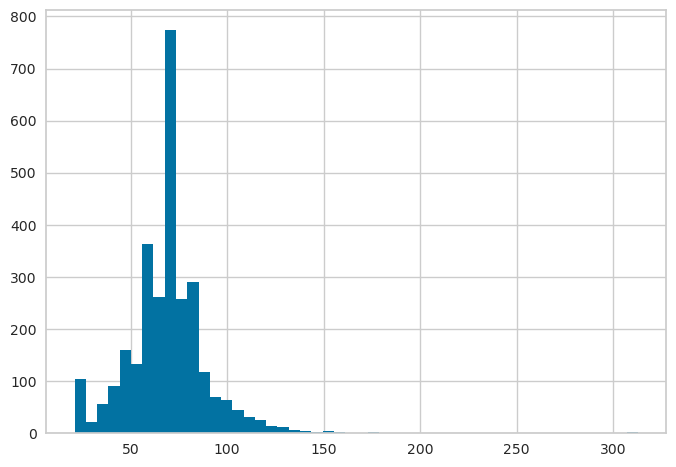

In [22]:
plt.hist(data['LotFrontage'], bins=50)
plt.show()

In the histogram above, we can see the tail in the right side, indicating positive skew. 

We want to identify all the numeric variables with skew, so we can transform them.

In [23]:
# Find numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns

# Calculate skewness for each numerical column
skew_vals = data[numerical_cols].skew()

# Find columns with absolute skewness greater than 0.5
skewed_cols = skew_vals[abs(skew_vals) > 0.5].index

print(skewed_cols)

Index(['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'], dtype='object')


We can transform these using the Numpy function "log1p":

In [24]:
for col in skewed_cols:
    if data[col].min() > 0:
        data[col] = np.log1p(data[col])

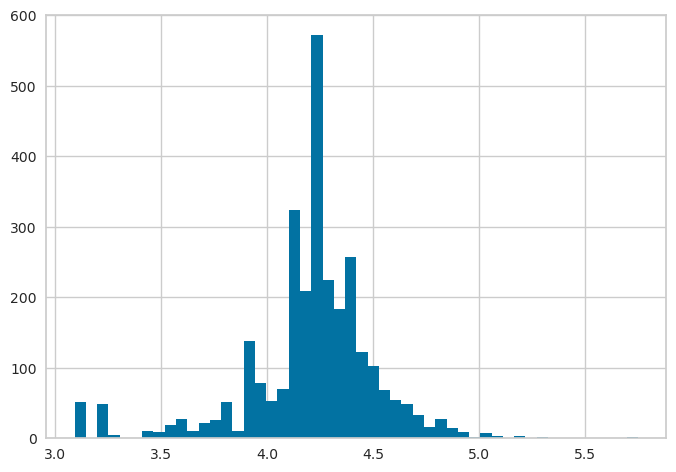

In [25]:
plt.hist(data['LotFrontage'], bins=50)
plt.show()

As you can see in the updated histogram, the data is much more normally distributed now.

# Encoding

We need to create dummy variables from the categorical variables in the data, since some machine learning algorithms require numerical data. This process is sometimes called "one-hot" encoding and there's a built-in pandas functions for it.

In [26]:
data = pd.get_dummies(data)

Any categorical variable that contained multiple values has now been split into binary dummy/indicator variables, as shown in the example below.

In [27]:
zoning = data.filter(regex='^MSZoning')
print(zoning)

      MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM
0                    0            0            0            1            0
1                    0            0            0            1            0
2                    0            0            0            1            0
3                    0            0            0            1            0
4                    0            0            0            1            0
...                ...          ...          ...          ...          ...
2914                 0            0            0            0            1
2915                 0            0            0            0            1
2916                 0            0            0            1            0
2917                 0            0            0            1            0
2918                 0            0            0            1            0

[2919 rows x 5 columns]


# Scaling

In [28]:
scaler = StandardScaler()
scaler.fit(data)

data = pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

# Target Transformation

Sometimes the target variable (outcome, y, etc.) is skewed and needs to be transformed.

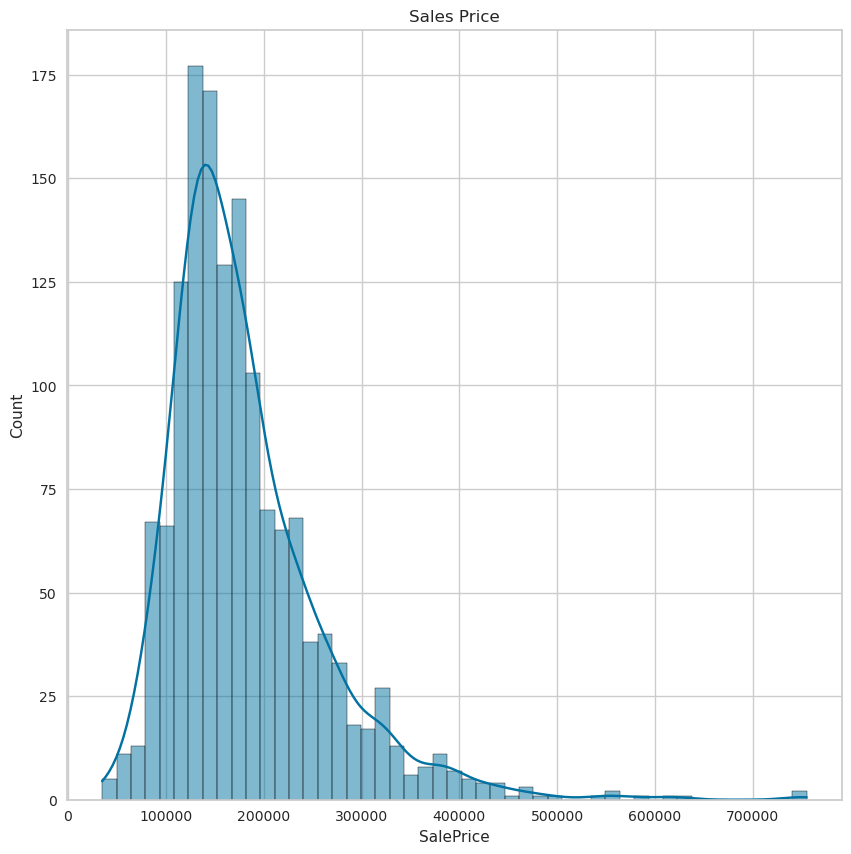

In [29]:
plt.figure(figsize=(10,10))
sns.histplot(target, kde=True) #kde gives us the smooth line
plt.title("Sales Price")
plt.show()

In [30]:
log_target = np.log(target)
log_target.dropna(inplace=True)
log_target

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

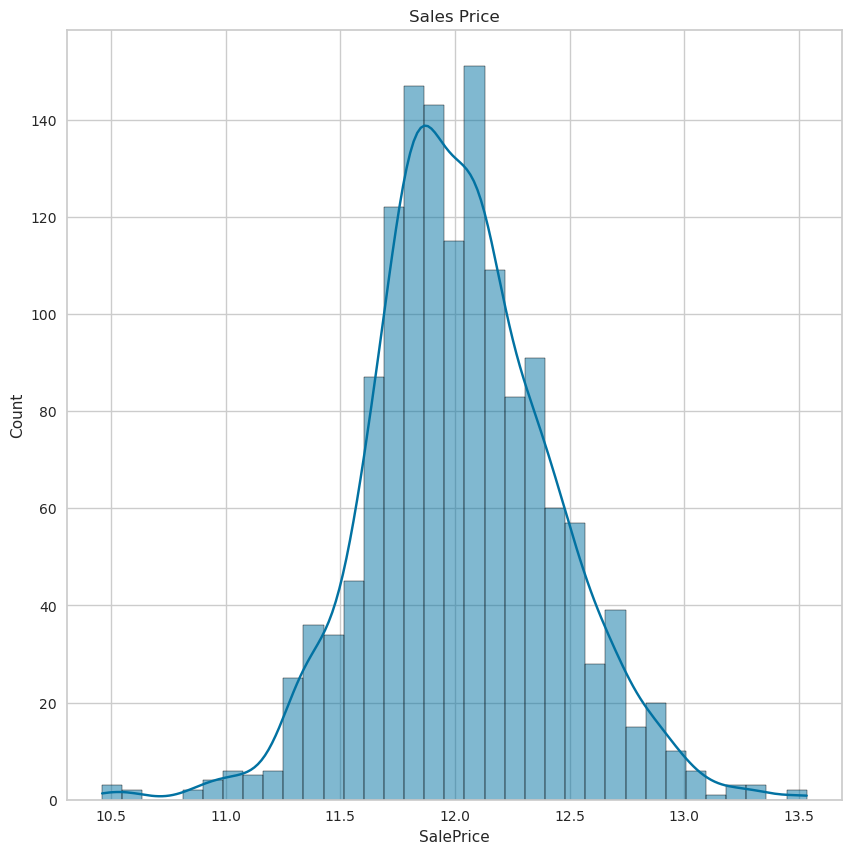

In [31]:
plt.figure(figsize=(10,10))
sns.histplot(log_target, kde=True) #kde gives us the smooth line
plt.title("Sales Price")
plt.show()

# Splitting the Data
Before model selection, we should split the data back into the train and test sets.


In [32]:
train = data.loc[:train.index.max(), :].copy()
test = data.loc[train.index.max() + 1:, :].reset_index(drop=True).copy()

# Model Selection

### Setup (PyCarat)

In [33]:
#Temporarily concat the target variable
setup(data=pd.concat([train, log_target], axis=1), target='SalePrice')

,Description,Value
0,Session id,3093
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 421)"
4,Transformed data shape,"(1460, 421)"
5,Transformed train set shape,"(1021, 421)"
6,Transformed test set shape,"(439, 421)"
7,Numeric features,420
8,Preprocess,True
9,Imputation type,simple


### Compare Potential Models (PyCarat)

In [34]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0847,0.0165,0.1278,0.8964,0.0099,0.0071,5.5420
gbr,Gradient Boosting Regressor,0.0921,0.0187,0.1356,0.8827,0.0105,0.0077,0.5110
lightgbm,Light Gradient Boosting Machine,0.0936,0.0192,0.1377,0.8795,0.0106,0.0078,0.8290
xgboost,Extreme Gradient Boosting,0.0977,0.0213,0.1447,0.8675,0.0112,0.0082,1.2180
rf,Random Forest Regressor,0.1014,0.0222,0.1479,0.8614,0.0114,0.0085,1.1360
et,Extra Trees Regressor,0.1027,0.0235,0.1514,0.8518,0.0117,0.0086,1.3890
br,Bayesian Ridge,0.0941,0.0245,0.1507,0.8455,0.0115,0.0079,0.1900
omp,Orthogonal Matching Pursuit,0.0911,0.0246,0.1487,0.8449,0.0113,0.0076,0.0930
ada,AdaBoost Regressor,0.1343,0.0318,0.1778,0.8004,0.0137,0.0112,0.3920
ridge,Ridge Regression,0.1076,0.0330,0.1761,0.7917,0.0135,0.0090,0.1000


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

The best performing model is CatBoost Regressor. 

### CatBoost Model

The CatBoost Regressor is a specific implementation of the gradient boosting algorithm for regression problems. It works by building an ensemble of decision trees, where each tree is built to correct the errors made by the previous tree. The process continues until the specified number of trees (or the stopping criteria) is reached.

In [35]:
catboost = CatBoostRegressor(verbose=0)

In [36]:
catboost.fit(train, log_target)

### Evaluate

Rather than just using the given test set, we're going to use cross-validation to get various scores

In [37]:
# Set the number of folds
kf= KFold(n_splits=10)

# Imput the information as shown in the following line
# cross_val_score(model, data, target, scoring method, cross validation object)
results = cross_val_score(catboost, train, log_target, scoring='neg_mean_squared_error', cv=kf)
results

array([-0.01247261, -0.00969122, -0.01159004, -0.02368528, -0.02083857,
       -0.01035088, -0.01504024, -0.00884408, -0.01732958, -0.01576759])

We can get the average mean squared error:

In [38]:
 np.mean(-results)

0.01456100847580293

Recall that we transformed our target variable. To make sense of this output, we need reverse that transformation. We also take the square root, since the error is squared.

In [39]:
avg_error = np.exp(np.sqrt(np.mean(-results)))
print('Average error is:',avg_error)

Average error is: 1.128251403617856


This error is exceptionally low, so we can create predictions using the test data to submit to see accurate our results are.

### Predictions

In [40]:
#Exponentiate the predictions to get the correct values
cb_predictions = np.exp(catboost.predict(test))

#Combine the test IDs
catboost_predictions = pd.concat([test_ids, pd.Series(cb_predictions, name= 'SalePrice')], axis=1)

In [41]:
catboost_predictions

,Id,SalePrice
0,1461,126235.624081
1,1462,160393.632584
2,1463,192236.900613
3,1464,191009.746036
4,1465,181729.168532
...,...,...
1454,2915,79008.562114
1455,2916,79853.809820
1456,2917,168304.847271
1457,2918,112870.653153


# Ensembling

Rather than rely on a single model, we can combine models to improve our predictions. This technique is known as ensembling. Here I'll use the top 5 models from the comparision we did earlier.

### Train the models

In [42]:
#Dictionary containing the desired models

models = {
    'CatBoost': CatBoostRegressor(verbose=0),
    'Bayesian Ridge': BayesianRidge(),
    'Orthogonal Matching Pursuit': OrthogonalMatchingPursuit(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Random Forest Regressor': RandomForestRegressor()
}

for name, model in models.items():
    print(f'Fitting {name}...complete.')
    model.fit(train, log_target)

Fitting CatBoost...complete.
Fitting Bayesian Ridge...complete.
Fitting Orthogonal Matching Pursuit...complete.
Fitting Gradient Boosting Regressor...complete.
Fitting Random Forest Regressor...complete.


### Results

In [43]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

We can print out the results and compare the mean error and stardard deviation.

In [44]:
for name, result in results.items():
    print("----------\n" + name) #creates a seperator between models
    print(np.mean(result)) #mean error across all folds
    print(np.std(result)) #standard deviation

----------
CatBoost
1.1267614531317314
0.021469016253641365
----------
Bayesian Ridge
1.1464675247453804
0.036429510460016044
----------
Orthogonal Matching Pursuit
1.1463484738388179
0.04609626548354265
----------
Gradient Boosting Regressor
1.1348801869019653
0.02002036578660135
----------
Random Forest Regressor
1.151893408120316
0.022043639036058823


# Combine Predictions

After seeing that all the models performed well is the previous step, we can combine the estimates to get our final predictions.

Depending on the performance of the models, you can choose to assign different weights to each model. Here, I've chosen to give the most weight (40%) to the best performing model (CatBoost). Keep in mind that the weights need to add up to 1 (100%).

You'll also notice that, as before, we have to exponentiate the results to get them into the proper units. 

In [45]:
combined_predictions = (
    0.4 * np.exp(models['CatBoost'].predict(test)) +
    0.2 * np.exp(models['Bayesian Ridge'].predict(test)) +
    0.2 * np.exp(models['Orthogonal Matching Pursuit'].predict(test)) +
    0.1 * np.exp(models['Gradient Boosting Regressor'].predict(test)) +
    0.1 * np.exp(models['Random Forest Regressor'].predict(test))
)

In [46]:
# Combine the test IDs
submission = pd.concat([test_ids, pd.Series(combined_predictions, name= 'SalePrice')], axis=1)

In [47]:
# Create the submission file
submission.to_csv('/kaggle/working/submission.csv', index=False, header=True)